# Synthetic Data (Poisson-Log-Normal)

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import torch
import numpy 
import matplotlib.pyplot as plt
import seaborn

import time
import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta
from torch.distributions import constraints

### Helper functions

In [13]:
def generate_fake_data(X_nl, g, k=1, alpha_scale=1E-2, alpha0_loc=-6.0, alpha0_scale=0.5, noise_scale=1E-2):
    """
    Args:
        X_nl: design matrix (with the covariates)
        g: int, number of genes
        k: int, number of cell types
        alpha_scale: scale for alpha
        alpha0_loc: loc of alpha0
        alpha0_scale: scale for alpha0
        noise_scale: noise scale
    """
    n, l = X_nl.shape[:2]
    cell_ids_n = torch.randint(low=0, high=k, size=[n])
    total_umi_n1 = torch.randint(low=250, high=3000, size=[n,1])
    alpha_klg = alpha_scale * torch.randn((k,l,g))
    alpha0_kg = alpha0_loc + alpha0_scale * torch.randn((k,g))
    eps_g = torch.randn(g) * noise_scale  # std per gene
    eps_ng = torch.randn(n,g) * eps_g
    
    log_mu_ng = alpha0_kg[cell_ids_n] + (X_nl[...,None] * alpha_klg[cell_ids_n]).sum(dim=-2) 
    mu_ng = (log_mu_ng + eps_ng).exp()
    rate_ng = total_umi_n1 * mu_ng
    counts_ng = torch.poisson(rate_ng).long()
    
    results = {
        "cell_type_ids_n": cell_ids_n,
        "counts_ng": counts_ng,
        "alpha0_kg": alpha0_kg,
        "alpha_klg": alpha_klg,
        "X_nl": X_nl
    }
    return results


def plot_few_gene_hist(cell_types_n, counts_ng, other_counts_ng=None, ncols=4):
    assert len(cell_types_n.shape) == 1 
    assert len(counts_ng.shape) == 2
    assert other_counts_ng is None or counts_ng.shape == other_counts_ng.shape
    assert counts_ng.shape[0] == cell_types_n.shape[0]
    
    def _to_torch(_x):
        if isinstance(_x, torch.Tensor):
            return _x
        elif isinstance(_x, numpy.ndarray):
            return torch.tensor(_x)
        else:
            raise Exception("Expected torch.tensor or numpy.ndarray. Received {0}".format(type(_x)))
    
    counts_ng = _to_torch(counts_ng)
    other_counts_ng = None if other_counts_ng is None else _to_torch(other_counts_ng)
    
    ctypes = torch.unique(cell_types_n)
    genes = counts_ng.shape[-1]
    
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = counts_ng[:,r]
        other_tmp = None if other_counts_ng is None else other_counts_ng[:,r]
        for c, c_type in enumerate(ctypes):
            tmp2 = tmp[cell_types_n == c_type]
            other_tmp2 = None if other_counts_ng is None else other_tmp[cell_types_n == c_type]
            if other_counts_ng is not None:
                barWidth=0.4
                
                y = torch.bincount(tmp2)
                x = torch.arange(y.shape[0]).cpu().numpy()
                other_y = torch.bincount(other_tmp2)
                other_x = torch.arange(other_y.shape[0]).cpu().numpy() + barWidth
                
                _ = axes[r,c].bar(x, y.cpu().numpy(), width = barWidth)
                _ = axes[r,c].bar(other_x, other_y.cpu().numpy(), width = barWidth)
            else:
                y = torch.bincount(tmp2)
                x = numpy.arange(y.shape[0])
                barWidth=0.9
                _ = axes[r,c].bar(x, y, width = barWidth)
    plt.close()
    return fig


def EMD_between_distributions(distA, distB, normalize: bool=False):
    """
    Eearth mover's distance (aka  Wasserstein distance) has a close form solution in 1D.
    See https://en.wikipedia.org/wiki/Wasserstein_metric)
    """

    sizeA = distA.shape[-1]
    sizeB = distB.shape[-1]
    max_size = max(sizeA, sizeB)
    min_size = min(sizeA, sizeB)
    delta_size = max_size - min_size
    
    padder = torch.nn.ConstantPad1d(padding=(0, delta_size), value=0)
    _distA = padder(distA)[...,:max_size]
    _distB = padder(distB)[...,:max_size]
    
    if normalize:
        normA = _distA.sum(dim=-1, keepdim=True)
        normB = _distB.sum(dim=-1, keepdim=True)
        _distA /= normA
        _distB /= normB
    
    # Actual caltulation 
    _distA_cum = torch.cumsum(_distA, axis=-1)
    _distB_cum = torch.cumsum(_distB, axis=-1)    
    EMD = (_distA_cum - _distB_cum).abs().sum(axis=-1)
    return EMD


def L1_between_distributions(distA, distB, normalize: bool=False):
    """ Simple L1 distance between two distributions. """
    sizeA = distA.shape[-1]
    sizeB = distB.shape[-1]
    max_size = max(sizeA, sizeB)
    min_size = min(sizeA, sizeB)
    delta_size = max_size - min_size
    
    padder = torch.nn.ConstantPad1d(padding=(0, delta_size), value=0)
    _distA = padder(distA)[...,:max_size]
    _distB = padder(distB)[...,:max_size]
    
    if normalize:
        normA = _distA.sum(dim=-1, keepdim=True)
        normB = _distB.sum(dim=-1, keepdim=True)
        _distA /= normA
        _distB /= normB
    
    # Actual calculation
    L1_norm = (_distA - _distB).abs().sum(axis=-1)
    return L1_norm


def compute_per_cell_type_distributions(cell_types_n, counts_ng):
    """
    Computes the per-cell-type distribution of all the genes
    
    Args:
        cell_types_n: 
        counts_ng:
    
    Returns:
        dist_kgi a tensor of shape (cell_types, genes, max_counts) whose entry represent the number of cells 
        of type k with i counts for gene g.  
    """
    counts_ng = counts_ng.int()
    
    unique_cell_types = torch.unique(cell_types_n)
    i_max = torch.max(counts_ng).item() + 1
    k = len(unique_cell_types)
    g = counts_ng.shape[-1]
    
    dist_kgi = torch.zeros((k,g,i_max))

    for ik, ctype in enumerate(unique_cell_types):
        counts_kg = counts_ng[cell_types_n == ctype]
        for ig in range(g):
            dist_kgi[ik,ig, :] = torch.bincount(counts_kg[:,ig], minlength=i_max) 
    return dist_kgi

### Generate fake data and visualize

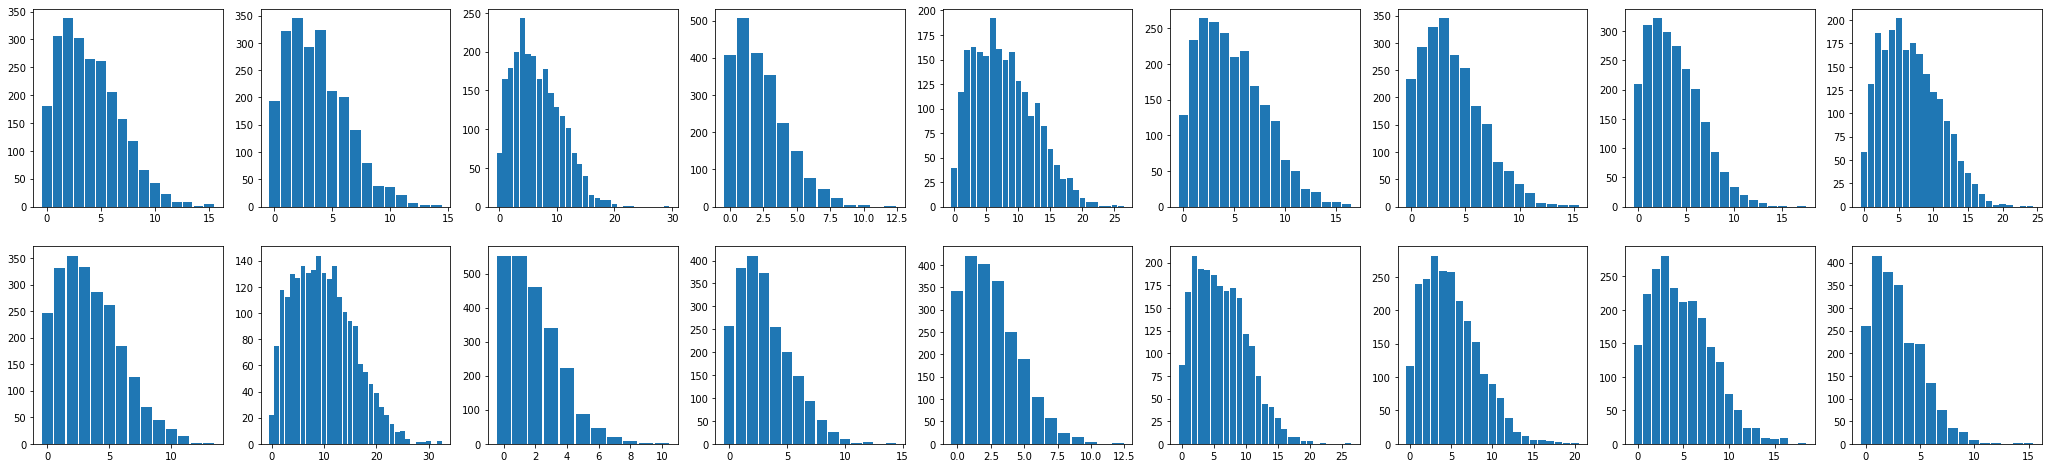

In [14]:
X_nl = torch.randn((20000,20))
fake_data = generate_fake_data(X_nl, g=500, k=9)

counts_ng = fake_data["counts_ng"]
cell_types_n = fake_data["cell_type_ids_n"]
fig = plot_few_gene_hist(cell_types_n, counts_ng[:,:2])
fig

### Package the fake data for the models

In [15]:
fake_dataset = {
    "counts" : fake_data["counts_ng"],
    "cell_type_codes" : fake_data["cell_type_ids_n"],
    "other_covariates" : fake_data["X_nl"]
}                               

# Define the initial parameters/priors for all models

In [16]:
# Define the parameter for the model prior
alpha0_loc = -6.0
alpha0_scale = 1E-2
alpha_scale = 1E-2
eps_g_low = 1E-4
eps_g_high = 1E-1

# Model A (no priors, i.e. Maximum Likelihood estimates MLE)

In [17]:
def model_poisson_log_normal_A(dataset, observed: bool=True):
    """ 
    This model has NO priors on the regression parameters and the noise in the rate
    """
    
    # Unpack the dataset
    counts_ng = dataset["counts"].long()
    covariates_nl = dataset['other_covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0, "Got {0}".format(k)
    assert isinstance(l, int) and l>0, "Got {0}".format(l)
    assert isinstance(n, int) and n>0, "Got {0}".format(n)
    assert isinstance(g, int) and g>0, "Got {0}".format(g)
    
    if torch.cuda.is_available(): 
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
        counts_ng = counts_ng.cuda()
    device = covariates_nl.device
      
    # Define the gene and cell plates. It make sense to subsample only gene and cells.
    cell_plate = pyro.plate("cells", size=n, dim=-3, device=device, subsample_size=None)
    gene_plate = pyro.plate("genes", size=g, dim=-1, device=device, subsample_size=None) 
    
    # define the parameters (on the correct device)
    eps_g = pyro.param("eps_g", 
                       dist.Uniform(low=eps_g_low, high=eps_g_high).sample(sample_shape=[g]), 
                       constraint=constraints.interval(eps_g_low, eps_g_high)).to(device)
    alpha0_k1g = pyro.param("alpha0", 
                            dist.Normal(loc=alpha0_loc, scale=alpha0_scale).sample(sample_shape=[k,1,g])).to(device)
    alpha_klg = pyro.param("alpha", 
                           dist.Normal(loc=0.0, scale=alpha_scale).sample(sample_shape=[k,l,g])).to(device)
    eps_n1g = pyro.param("eps_n1g", dist.Normal(loc=0, scale=eps_g).sample(sample_shape=[n,1])).to(device)
        
    assert eps_g.shape == torch.Size([g]), "Got {0}".format(eps_g.shape)
    assert alpha0_k1g.shape == torch.Size([k,1,g]), "Got {0}".format(alpha0_k1g.shape)
    assert alpha_klg.shape == torch.Size([k,l,g]), "Got {0}".format(alpha_klg.shape)
    assert eps_n1g.shape == torch.Size([n,1,g]), "Got {0}".format(eps_n1g.shape)
    
    
    with cell_plate as ind_n:
        cell_ids_sub_n = cell_type_ids_n[ind_n]
        alpha0_n1g = alpha0_k1g[cell_ids_sub_n]
        alpha_nlg = alpha_klg[cell_ids_sub_n]
        covariate_sub_nl1 = covariates_nl[cell_ids_sub_n].unsqueeze(dim=-1)
        log_mu_n1g = alpha0_n1g + torch.sum(covariate_sub_nl1 * alpha_nlg, dim=-2, keepdim=True)
        total_umi_n11 = counts_ng[ind_n].sum(dim=-1, keepdim=True).unsqueeze(dim=-1)
        eps_sub_n1g = eps_n1g[ind_n]
        
        with gene_plate as ind_g: 
            mu_n1g = (log_mu_n1g[...,ind_g] + eps_sub_n1g[..., ind_g]).exp()
            rate_n1g = mu_n1g * total_umi_n11 
            
            pyro.sample("counts", dist.Poisson(rate_n1g), 
                        obs=counts_ng[ind_n, None][...,ind_g] if observed else None)

Trace Shapes:                      
 Param Sites:                      
        eps_g                   500
       alpha0           9     1 500
        alpha           9    20 500
      eps_n1g       20000     1 500
Sample Sites:                      
   cells dist                     |
        value             20000   |
     log_prob                     |
   genes dist                     |
        value               500   |
     log_prob                     |
  counts dist 20000     1   500   |
        value 20000     1   500   |
     log_prob 20000     1   500   |


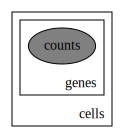

In [18]:
def guide_poisson_log_normal_A(*args, **kargs):
    pass

trace = poutine.trace(model_poisson_log_normal_A).get_trace(fake_dataset)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

pyro.render_model(model_poisson_log_normal_A, model_kwargs={"dataset": fake_dataset})

# MODEL B (with priors, i.e. MAP estimates)

In [19]:
def model_poisson_log_normal_B(dataset, observed: bool = True):
    """ 
    This model has priors on the regression parameters and the noise in the rate
    """
    
    # Unpack the dataset
    counts_ng = dataset["counts"].long()
    covariates_nl = dataset['other_covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0, "Got {0}".format(k)
    assert isinstance(l, int) and l>0, "Got {0}".format(l)
    assert isinstance(n, int) and n>0, "Got {0}".format(n)
    assert isinstance(g, int) and g>0, "Got {0}".format(g)
    
    if torch.cuda.is_available(): 
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
        counts_ng = counts_ng.cuda()
    device = covariates_nl.device
      
    # Define the gene and cell plates. It make sense to subsample only gene and cells.
    cell_plate = pyro.plate("cells", size=n, dim=-3, device=device, subsample_size=None) 
    cell_types_plate = pyro.plate("cell_types", size=k, dim=-3, device=device)
    covariate_plate = pyro.plate("covariate", size=l, dim=-2, device=device)
    gene_plate = pyro.plate("genes", size=g, dim=-1, device=device, subsample_size=None) 
    
    with gene_plate as ind_g: 
        eps_g = pyro.sample("eps_g", dist.Uniform(low=eps_g_low, high=eps_g_high)).to(device)
        with cell_types_plate:
            alpha0_k1g = pyro.sample("alpha0", dist.Normal(loc=alpha0_loc, scale=alpha0_scale)).to(device)
            with covariate_plate:
                alpha_klg = pyro.sample("alpha", dist.Normal(loc=0, scale=alpha_scale)).to(device)
    
    # assert eps_g.shape == torch.Size([len(ind_g)])
    # assert alpha0_k1g.shape == torch.Size([k,1,len(ind_g)]), "Got {0}".format(alpha0_k1g.shape)
    # assert alpha_klg.shape == torch.Size([k,l,len(ind_g)]), "Got {0}".format(alpha_klg.shape)
    
    with cell_plate as ind_n:
        cell_ids_sub_n = cell_type_ids_n[ind_n]
        alpha0_n1g = alpha0_k1g[cell_ids_sub_n]
        alpha_nlg = alpha_klg[cell_ids_sub_n]
        covariate_sub_nl1 = covariates_nl[cell_ids_sub_n].unsqueeze(dim=-1)
        log_mu_n1g = alpha0_n1g + torch.sum(covariate_sub_nl1 * alpha_nlg, dim=-2, keepdim=True)
        total_umi_n11 = counts_ng[ind_n].sum(dim=-1, keepdim=True).unsqueeze(dim=-1)
    
        assert alpha0_n1g.shape == torch.Size([len(ind_n), 1, len(ind_g)]), "Got {0}".format(alpha0_n1g.shape)
        assert alpha0_n1g.shape == torch.Size([len(ind_n), 1, len(ind_g)]), "Got {0}".format(alpha0_n1g.shape)
        assert total_umi_n11.shape == torch.Size([len(ind_n), 1, 1]), "Got {0}".format(total_umi_n11.shape)

        with gene_plate as ind_g: 
            eps_n1g = pyro.sample("eps_n1g", dist.Normal(loc=0, scale=eps_g))
            mu_n1g = (log_mu_n1g + eps_n1g).exp()
            rate_n1g = mu_n1g * total_umi_n11 
            pyro.sample("counts", dist.Poisson(rate_n1g), 
                        obs=counts_ng[ind_n, None][...,ind_g] if observed else None)

  Trace Shapes:                 
   Param Sites:                 
  Sample Sites:                 
     cells dist                |
          value          20000 |
       log_prob                |
cell_types dist                |
          value              9 |
       log_prob                |
 covariate dist                |
          value             20 |
       log_prob                |
     genes dist                |
          value            500 |
       log_prob                |
     eps_g dist            500 |
          value            500 |
       log_prob            500 |
    alpha0 dist     9  1   500 |
          value     9  1   500 |
       log_prob     9  1   500 |
     alpha dist     9 20   500 |
          value     9 20   500 |
       log_prob     9 20   500 |
   eps_n1g dist 20000  1   500 |
          value 20000  1   500 |
       log_prob 20000  1   500 |
    counts dist 20000  1   500 |
          value 20000  1   500 |
       log_prob 20000  1   500 |


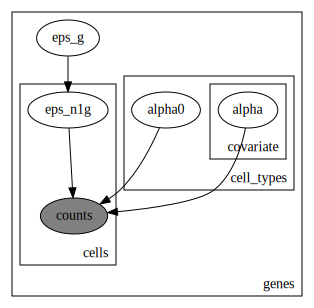

In [20]:
guide_poisson_log_normal_B = pyro.infer.autoguide.AutoDelta(model_poisson_log_normal_B)

trace = poutine.trace(model_poisson_log_normal_B).get_trace(fake_dataset)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

pyro.render_model(model_poisson_log_normal_B, model_kwargs={"dataset": fake_dataset})

# Model C (priors for alpha but not for alpha0)

In [21]:
def model_poisson_log_normal_C(dataset, observed: bool = True):
    """ 
    This model has priors on the regression parameters and the noise in the rate
    """
    
    # Unpack the dataset
    counts_ng = dataset["counts"].long()
    covariates_nl = dataset['other_covariates'].float()  
    cell_type_ids_n = dataset['cell_type_codes'].long()  # ids: 0,1,...,K-1
    k = cell_type_ids_n.max().item()+1
    
    n, g = counts_ng.shape[:2]
    n, l = covariates_nl.shape[:2]
    n = cell_type_ids_n.shape[0]  
    assert isinstance(k, int) and k>0, "Got {0}".format(k)
    assert isinstance(l, int) and l>0, "Got {0}".format(l)
    assert isinstance(n, int) and n>0, "Got {0}".format(n)
    assert isinstance(g, int) and g>0, "Got {0}".format(g)
    
    if torch.cuda.is_available(): 
        covariates_nl = covariates_nl.cuda()
        cell_type_ids_n = cell_type_ids_n.cuda()
        counts_ng = counts_ng.cuda()
    device = covariates_nl.device
    
    # Define the gene and cell plates. It make sense to subsample only gene and cells.
    cell_plate = pyro.plate("cells", size=n, dim=-3, device=device, subsample_size=None) 
    cell_types_plate = pyro.plate("cell_types", size=k, dim=-3, device=device)
    covariate_plate = pyro.plate("covariate", size=l, dim=-2, device=device)
    gene_plate = pyro.plate("genes", size=g, dim=-1, device=device, subsample_size=None) 
    
    
    with gene_plate as ind_g: 
        eps_g = pyro.sample("eps_g", dist.Uniform(low=eps_g_low, high=eps_g_high)).to(device)
        with cell_types_plate:
            alpha0_k1g = pyro.param("alpha0", 
                                    dist.Normal(loc=alpha0_loc, scale=alpha0_scale).sample(sample_shape=[k,1,g])).to(device)
            with covariate_plate:
                alpha_klg = pyro.sample("alpha", dist.Normal(loc=0, scale=alpha_scale)).to(device)
    
    # assert eps_g.shape == torch.Size([len(ind_g)])
    # assert alpha0_k1g.shape == torch.Size([k,1,len(ind_g)]), "Got {0}".format(alpha0_k1g.shape)
    # assert alpha_klg.shape == torch.Size([k,l,len(ind_g)]), "Got {0}".format(alpha_klg.shape)
    
    with cell_plate as ind_n:
        cell_ids_sub_n = cell_type_ids_n[ind_n]
        alpha0_n1g = alpha0_k1g[cell_ids_sub_n]
        alpha_nlg = alpha_klg[cell_ids_sub_n]
        covariate_sub_nl1 = covariates_nl[cell_ids_sub_n].unsqueeze(dim=-1)
        log_mu_n1g = alpha0_n1g + torch.sum(covariate_sub_nl1 * alpha_nlg, dim=-2, keepdim=True)
        total_umi_n11 = counts_ng[ind_n].sum(dim=-1, keepdim=True).unsqueeze(dim=-1)
    
        assert alpha0_n1g.shape == torch.Size([len(ind_n), 1, len(ind_g)]), "Got {0}".format(alpha0_n1g.shape)
        assert alpha0_n1g.shape == torch.Size([len(ind_n), 1, len(ind_g)]), "Got {0}".format(alpha0_n1g.shape)
        assert total_umi_n11.shape == torch.Size([len(ind_n), 1, 1]), "Got {0}".format(total_umi_n11.shape)

        with gene_plate as ind_g: 
            eps_n1g = pyro.sample("eps_n1g", dist.Normal(loc=0, scale=eps_g))
            mu_n1g = (log_mu_n1g + eps_n1g).exp()
            rate_n1g = mu_n1g * total_umi_n11 
            pyro.sample("counts", dist.Poisson(rate_n1g), 
                        obs=counts_ng[ind_n, None][...,ind_g] if observed else None)

  Trace Shapes:                   
   Param Sites:                   
         alpha0        9     1 500
  Sample Sites:                   
     cells dist                  |
          value          20000   |
       log_prob                  |
cell_types dist                  |
          value              9   |
       log_prob                  |
 covariate dist                  |
          value             20   |
       log_prob                  |
     genes dist                  |
          value            500   |
       log_prob                  |
     eps_g dist            500   |
          value            500   |
       log_prob            500   |
     alpha dist     9 20   500   |
          value     9 20   500   |
       log_prob     9 20   500   |
   eps_n1g dist 20000  1   500   |
          value 20000  1   500   |
       log_prob 20000  1   500   |
    counts dist 20000  1   500   |
          value 20000  1   500   |
       log_prob 20000  1   500   |


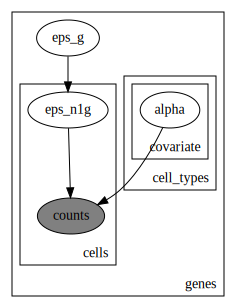

In [22]:
guide_poisson_log_normal_C = pyro.infer.autoguide.AutoDelta(model_poisson_log_normal_C)

trace = poutine.trace(model_poisson_log_normal_C).get_trace(fake_dataset)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

pyro.render_model(model_poisson_log_normal_C, model_kwargs={"dataset": fake_dataset})

# Train all models

In [23]:
def train(model, guide, model_args=[], model_kargs=dict(), lr=0.005, n_steps=2500, print_frequency=50, clear_param_store=True):
    if clear_param_store:
        pyro.clear_param_store()
    
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    for i in range(n_steps):
        loss = svi.step(*model_args, **model_kargs)
        if i % print_frequency == 0:
            print('[iter {}]  loss: {:.4f}'.format(i, loss))

### train model A

In [24]:
start_time = time.time()
print("Starting training")

train(model_poisson_log_normal_A, guide_poisson_log_normal_A, 
      model_kargs = {"dataset": fake_dataset, "observed": True}, 
      n_steps=1, #2001, 
      print_frequency=50,
     clear_param_store=True)

delta_time = time.time()-start_time
print("Traning time was {0:.3f} seconds".format(delta_time))

pyro.get_param_store().save(filename="params_model_A.pt")

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

Starting training
[iter 0]  loss: 26888788.0000
Traning time was 1.261 seconds
eps_g torch.Size([500])
alpha0 torch.Size([9, 1, 500])
alpha torch.Size([9, 20, 500])
eps_n1g torch.Size([20000, 1, 500])


### train model B

In [25]:
start_time = time.time()
print("Starting training")

train(model_poisson_log_normal_B, guide_poisson_log_normal_B, 
      model_kargs = {"dataset": fake_dataset, "observed": True}, 
      n_steps=1, #2001, 
      print_frequency=50,
      clear_param_store=True)

delta_time = time.time()-start_time
print("Traning time was {0:.3f} seconds".format(delta_time))

pyro.get_param_store().save(filename="params_model_B.pt")

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

Starting training
[iter 0]  loss: 5854022.3812
Traning time was 16.847 seconds
AutoDelta.eps_g torch.Size([500])
AutoDelta.alpha0 torch.Size([9, 1, 500])
AutoDelta.alpha torch.Size([9, 20, 500])
AutoDelta.eps_n1g torch.Size([20000, 1, 500])


### train model C

In [26]:
start_time = time.time()
print("Starting training")

train(model_poisson_log_normal_C, guide_poisson_log_normal_C, 
      model_kargs = {"dataset": fake_dataset, "observed": True}, 
      n_steps=1, #2001, 
      print_frequency=50,
      clear_param_store=True)

delta_time = time.time()-start_time
print("Traning time was {0:.3f} seconds".format(delta_time))

pyro.get_param_store().save(filename="params_model_C.pt")

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

Starting training
[iter 0]  loss: 5977690.5199
Traning time was 17.076 seconds
alpha0 torch.Size([9, 1, 500])
AutoDelta.eps_g torch.Size([500])
AutoDelta.alpha torch.Size([9, 20, 500])
AutoDelta.eps_n1g torch.Size([20000, 1, 500])


### Plot the predicted_counts vs the real_counts

In [27]:
from pyro.infer import Predictive

In [28]:
pyro.get_param_store().load(filename="params_model_A.pt")
predictive_A = Predictive(model_poisson_log_normal_A, guide=guide_poisson_log_normal_A, num_samples=2, 
                        return_sites={"counts"})
samples_A = predictive_A.get_samples(fake_dataset, observed=False)
for k, v in samples_A.items():
    print(f"{k}: {tuple(v.shape)}")

counts: (2, 20000, 1, 500)


In [29]:
pyro.get_param_store().load(filename="params_model_B.pt")
predictive_B = Predictive(model_poisson_log_normal_B, guide=guide_poisson_log_normal_B, num_samples=2, 
                        return_sites={"counts"})
samples_B = predictive_B.get_samples(fake_dataset, observed=False)
for k, v in samples_B.items():
    print(f"{k}: {tuple(v.shape)}")

counts: (2, 20000, 1, 500)


In [30]:
pyro.get_param_store().load(filename="params_model_B.pt")
predictive_C = Predictive(model_poisson_log_normal_C, guide=guide_poisson_log_normal_C, num_samples=2, 
                        return_sites={"counts"})
samples_C = predictive_C.get_samples(fake_dataset, observed=False)
for k, v in samples_C.items():
    print(f"{k}: {tuple(v.shape)}")

counts: (2, 20000, 1, 500)


In [31]:
assert torch.any(samples_A["counts"][0] != samples_A["counts"][1])
assert torch.any(samples_B["counts"][0] != samples_B["counts"][1])
assert torch.any(samples_C["counts"][0] != samples_C["counts"][1])

In [32]:
cell_types_n = fake_dataset["cell_type_codes"]
true_counts_ng = fake_dataset['counts']
predA_counts_ng = samples_A["counts"][0].squeeze()
predB_counts_ng = samples_B["counts"][0].squeeze()
predC_counts_ng = samples_C["counts"][0].squeeze()

print(cell_types_n.shape, true_counts_ng.shape, predA_counts_ng.shape, predB_counts_ng.shape, predC_counts_ng.shape)

torch.Size([20000]) torch.Size([20000, 500]) torch.Size([20000, 500]) torch.Size([20000, 500]) torch.Size([20000, 500])


In [33]:
fig_A = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predA_counts_ng[:,:2].int(), ncols=3)
fig_B = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predB_counts_ng[:,:2].int(), ncols=3)
fig_C = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predC_counts_ng[:,:2].int(), ncols=3)

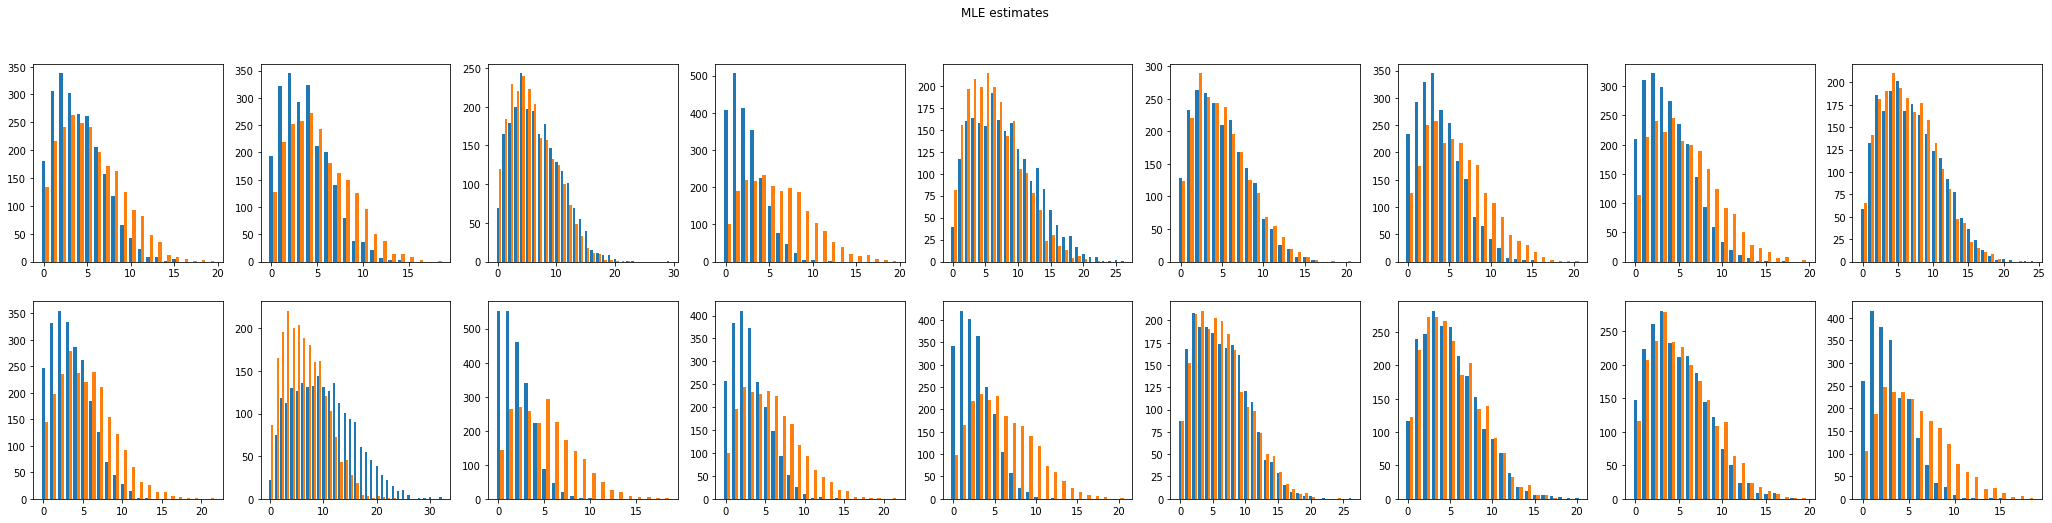

In [34]:
_ = fig_A.suptitle("MLE estimates")
fig_A

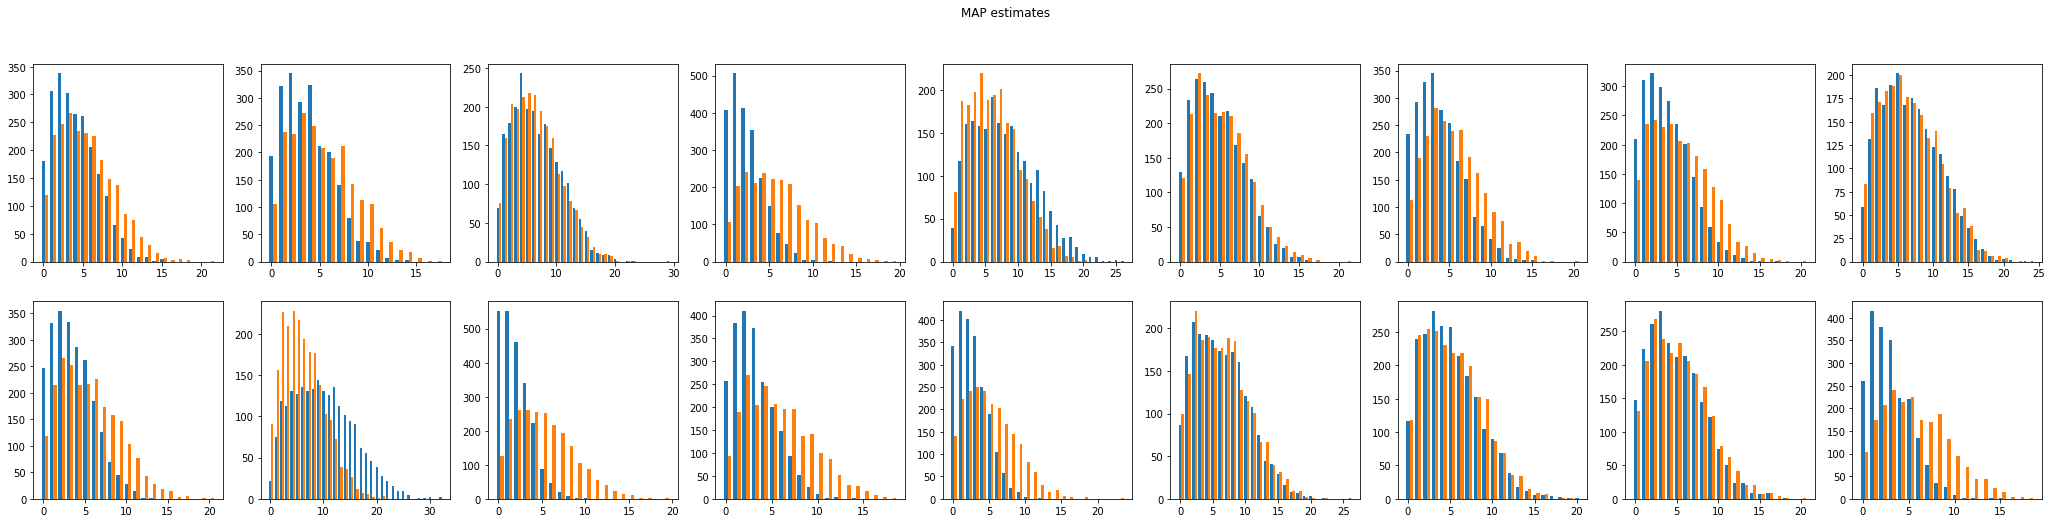

In [35]:
_ = fig_B.suptitle("MAP estimates")
fig_B

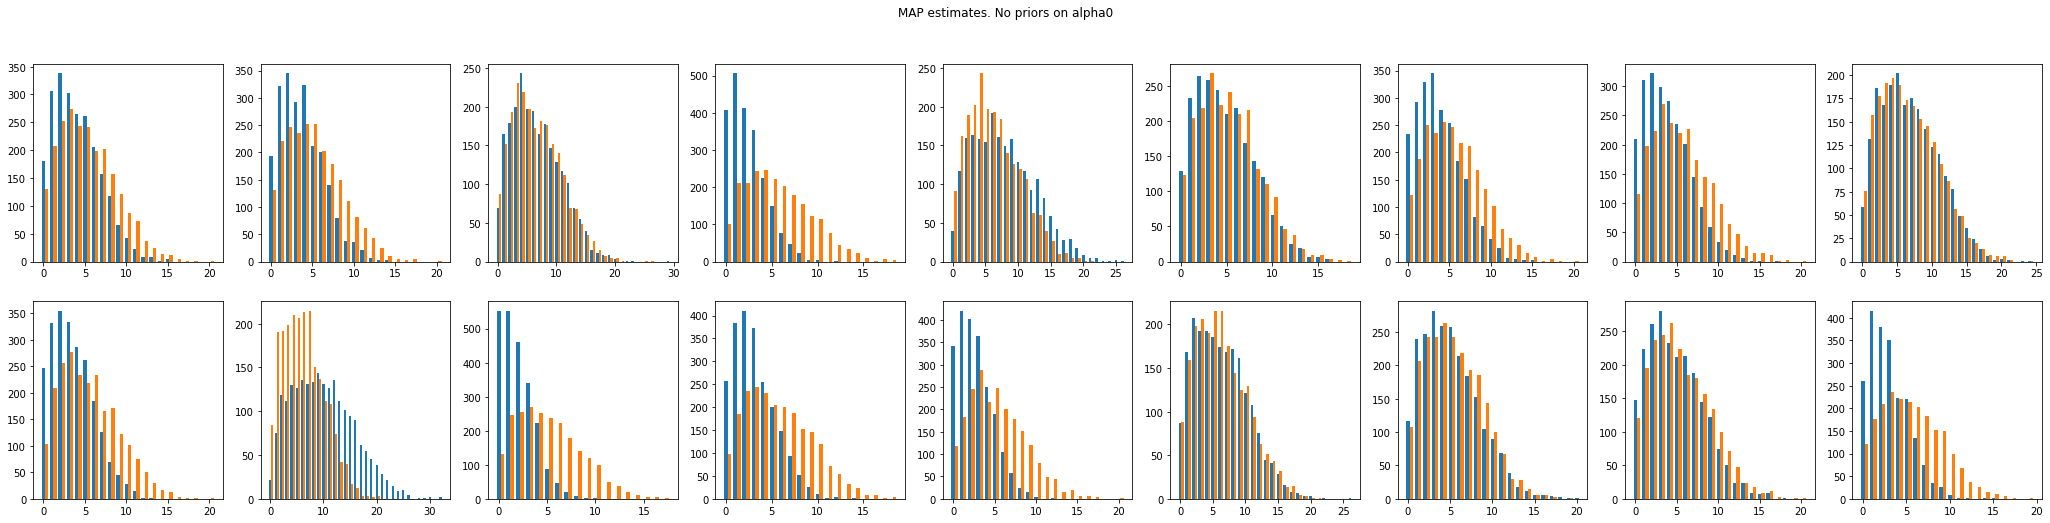

In [36]:
_ = fig_C.suptitle("MAP estimates. No priors on alpha0")
fig_C

In [37]:
pyro.clear_param_store()
pyro.get_param_store().load(filename="params_model_A.pt")
for k,v in pyro.get_param_store().items():
    print(k, v.shape)
eps_g_A = pyro.get_param_store().get_param("eps_g").detach().cpu().numpy()
alpha0_A = pyro.get_param_store().get_param("alpha0").detach().cpu().numpy()
alpha_A = pyro.get_param_store().get_param("alpha").detach().cpu().numpy()
    
print("======================")

pyro.clear_param_store()
pyro.get_param_store().load(filename="params_model_B.pt")
for k,v in pyro.get_param_store().items():
    print(k, v.shape)
eps_g_B = pyro.get_param_store().get_param("AutoDelta.eps_g").detach().cpu().numpy()
alpha0_B = pyro.get_param_store().get_param("AutoDelta.alpha0").detach().cpu().numpy()
alpha_B = pyro.get_param_store().get_param("AutoDelta.alpha").detach().cpu().numpy()
    
print("======================")
    
pyro.clear_param_store()
pyro.get_param_store().load(filename="params_model_C.pt")
for k,v in pyro.get_param_store().items():
    print(k, v.shape)
eps_g_C = pyro.get_param_store().get_param("AutoDelta.eps_g").detach().cpu().numpy()
alpha0_C = pyro.get_param_store().get_param("alpha0").detach().cpu().numpy()
alpha_C = pyro.get_param_store().get_param("AutoDelta.alpha").detach().cpu().numpy()


eps_g torch.Size([500])
alpha0 torch.Size([9, 1, 500])
alpha torch.Size([9, 20, 500])
eps_n1g torch.Size([20000, 1, 500])
AutoDelta.eps_g torch.Size([500])
AutoDelta.alpha0 torch.Size([9, 1, 500])
AutoDelta.alpha torch.Size([9, 20, 500])
AutoDelta.eps_n1g torch.Size([20000, 1, 500])
alpha0 torch.Size([9, 1, 500])
AutoDelta.eps_g torch.Size([500])
AutoDelta.alpha torch.Size([9, 20, 500])
AutoDelta.eps_n1g torch.Size([20000, 1, 500])


In [38]:
# _ = seaborn.jointplot(x=eps_g_B.flatten(), y=eps_g_C.flatten())

In [39]:
# _ = seaborn.jointplot(x=eps_g_B.flatten(), y=eps_g_A.flatten())

In [40]:
# _ = seaborn.jointplot(x=eps_g_C.flatten(), y=eps_g_A.flatten())

## Quantify the variance 
1. at the level of distributions
2. at the level of single predictions

### at the level of distributions

In [41]:
true_dist_kgi = compute_per_cell_type_distributions(cell_types_n, true_counts_ng)
predA_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predA_counts_ng)
predB_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predB_counts_ng)
predC_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predC_counts_ng)

In [42]:
L1_norm_A = L1_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
L1_norm_B = L1_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
L1_norm_C = L1_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

EMD_norm_A = EMD_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
EMD_norm_B = EMD_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
EMD_norm_C = EMD_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

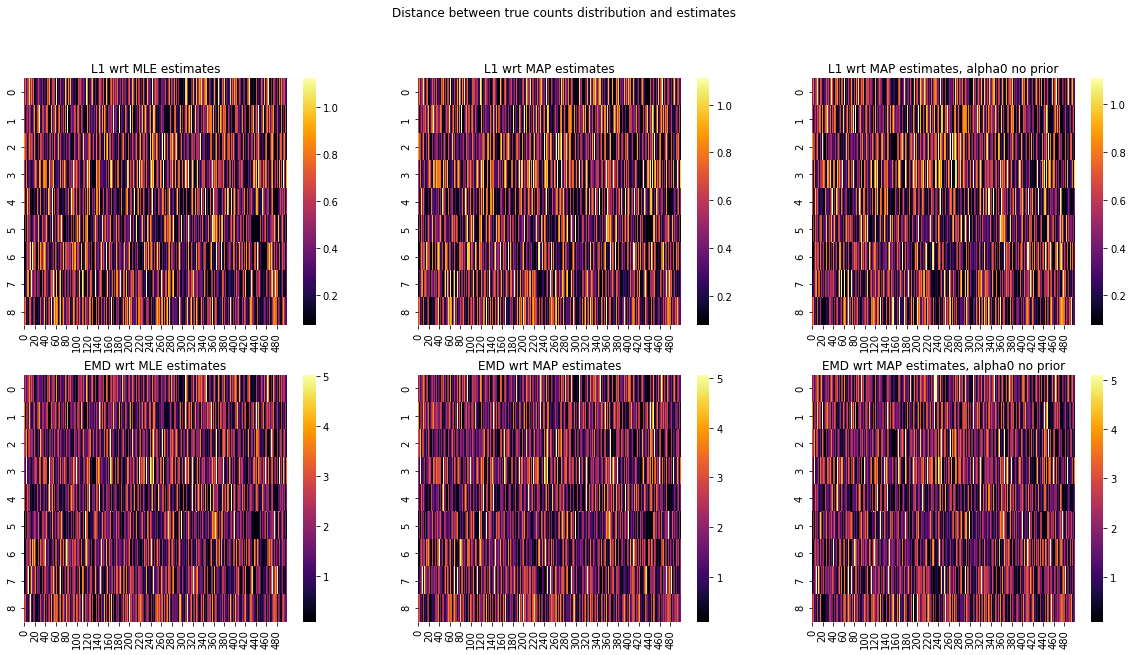

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(L1_norm_A, cmap="inferno", robust=True, ax=axes[0,0])
_ = seaborn.heatmap(L1_norm_B, cmap="inferno", robust=True, ax=axes[0,1])
_ = seaborn.heatmap(L1_norm_C, cmap="inferno", robust=True, ax=axes[0,2])
_ = axes[0,0].set_title("L1 wrt MLE estimates")
_ = axes[0,1].set_title("L1 wrt MAP estimates")
_ = axes[0,2].set_title("L1 wrt MAP estimates, alpha0 no prior")

_ = seaborn.heatmap(EMD_norm_A, cmap="inferno", robust=True, ax=axes[1,0])
_ = seaborn.heatmap(EMD_norm_B, cmap="inferno", robust=True, ax=axes[1,1])
_ = seaborn.heatmap(EMD_norm_C, cmap="inferno", robust=True, ax=axes[1,2])
_ = axes[1,0].set_title("EMD wrt MLE estimates")
_ = axes[1,1].set_title("EMD wrt MAP estimates")
_ = axes[1,2].set_title("EMD wrt MAP estimates, alpha0 no prior")

In [44]:
print(L1_norm_A.median(), L1_norm_B.median(), L1_norm_C.median())
print(EMD_norm_A.median(), EMD_norm_B.median(), EMD_norm_C.median())

tensor(0.3798) tensor(0.3759) tensor(0.3775)
tensor(1.6062) tensor(1.6015) tensor(1.5967)


## At the level of single predictions

In [64]:
from tissue_purifier.misc_utils.validation import (
    create_null_distribution,
    create_heldout_distribution
)

null_dist = create_null_distribution(
    cell_types_n=cell_types_n, 
    counts_ng=counts_ng[:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

In [65]:
heldout_dist = create_heldout_distribution(
    cell_types_n=cell_types_n, 
    true_counts_ng=counts_ng[:,:10], 
    pred_counts_ng=counts_ng[:,:10]+1,
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

In [69]:
#heldout_dist

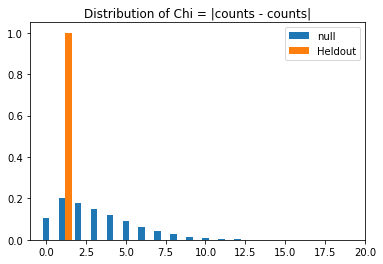

In [86]:
x_null = null_dist["cell_type_0"][0,:] / numpy.sum(null_dist["cell_type_0"][0,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][0,:] / numpy.sum(heldout_dist["cell_type_0"][0,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

In [47]:
# plt.bar(numpy.arange(norm_true_dist_kgi[0,4].shape[-1]), norm_true_dist_kgi[0,4])    
# plt.bar(numpy.arange(norm_predA_dist_kgi[0,4].shape[-1]), norm_predA_dist_kgi[0,4])    
# plt.bar(numpy.arange(norm_predB_dist_kgi[0,4].shape[-1]), norm_predB_dist_kgi[0,4])    

In [48]:
# print(cell_types_n.shape, true_counts_ng.shape, predA_counts_ng.shape, predB_counts_ng.shape)